# YouTube trending videos

In [40]:
%matplotlib inline


import numpy as np
import pandas as pd
from numpy import nan

# import json
# import math
import os
from typing import List
# import re
# from IPython.display import Image

import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
import pandas as pd
# from tqdm.notebook import tqdm
from scipy import stats

from helpers.categories import get_categories_dict
from helpers.files import load_csv

## Etap 3 - Ocena ważności atrybutów


### Wczytanie danych zgrupowanych po id

['GB_videos_5p.csv', 'US_videos_5p.csv']


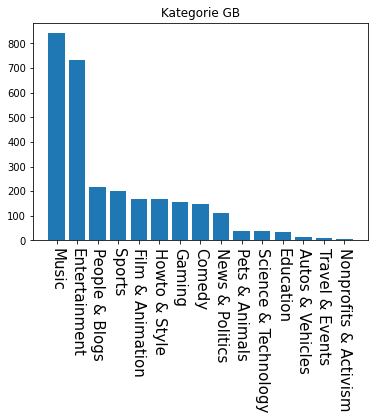

Kategorie GB Liczba wartości 'nan':394


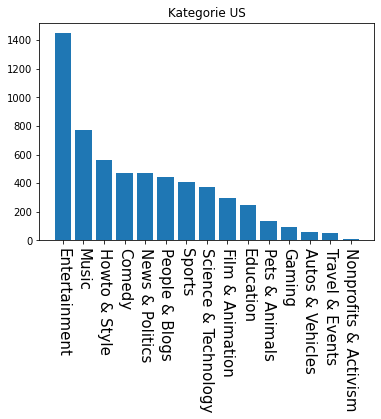

Kategorie US Liczba wartości 'nan':494


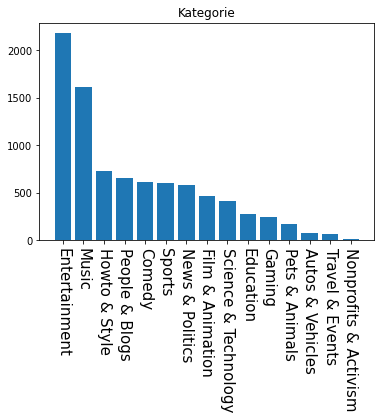

Kategorie Liczba wartości 'nan':888


In [41]:
numeric_attrs = [
    "views", "likes", "dislikes", "comment_count", "description_len", "title_len", "channel_title_len",
    "publish_time_day_of_week", "publish_time_hour_of_day"
]


def plot_categories(title: str, categories_dict: dict, data: pd.DataFrame) -> list:
    nan_count = data["new_category_id"].isna().sum()
    plt.title(title)
    attr_c = data["new_category_id"].value_counts()
    attr_c = attr_c.rename_axis("new_category_id").reset_index(name="count")
    labels = [categories_dict[i] for i in attr_c["new_category_id"]]
    plt.bar(labels, attr_c["count"])
    plt.xticks(rotation=270, fontsize=15)
    plt.show()

    print(f"{title} Liczba wartości 'nan':{nan_count}")
    return attr_c["new_category_id"].tolist()


data_dir = "ped3_data"
# data_path = os.path.join("..", "categories_data")
gb_videos, us_videos = load_csv(data_dir)
# gb_videos = pd.read_csv(os.path.join(data_path, "GB_videos_5p.csv"), sep=";", index_col=0)
# us_videos = pd.read_csv(os.path.join(data_path, "US_videos_5p.csv"), sep=";", index_col=0)
videos = pd.concat([gb_videos, us_videos])
for name in numeric_attrs:
    videos[name] = videos[name].apply(lambda x: eval(x))
videos.head(10)

categories_dict = get_categories_dict()

d = [gb_videos, us_videos]
names = ["Kategorie GB", "Kategorie US"]
for df, name in zip(d, names):
    plot_categories(name, categories_dict, df)
categories = plot_categories("Kategorie", categories_dict, videos)


TODO komentarz nizbalansowane dane

In [42]:
for i in numeric_attrs:
    videos[i] = videos[i].apply(lambda x: x[-1])
videos["category_name"] = videos["new_category_id"].apply(lambda x: np.nan if np.isnan(x) else categories_dict[x])
grouped = videos.groupby("category_name")

grouped.agg([np.mean, np.std])
# videos.describe()

category_id                   views                \
                             mean       std          mean           std   
category_name                                                             
Autos & Vehicles         3.571429  5.879747  1.141300e+06  2.401132e+06   
Comedy                  23.000000  0.000000  1.528191e+06  1.946888e+06   
Education               26.975309  0.156150  6.373416e+05  9.994431e+05   
Entertainment           23.913738  2.152335  2.055705e+06  7.065023e+06   
Film & Animation         1.750000  3.955970  2.478536e+06  5.384405e+06   
Gaming                  20.066667  0.632456  1.234628e+06  1.995944e+06   
Howto & Style           25.971014  0.310231  8.221302e+05  2.359169e+06   
Music                   10.172897  1.547888  9.680061e+06  2.703447e+07   
News & Politics         25.000000  0.000000  5.241834e+05  1.188799e+06   
Nonprofits & Activism   29.000000  0.000000  3.416222e+06  8.171904e+06   
People & Blogs          22.046296  0.357882  1.392806e+06  3.906512e+06   
Pets & Animals          14.735849  1.923048  8.036315e+05  1.204420e+06   
Science & Technology    27.884615  0.672738  1.148030e+06  2.930253e+06   
Sports                  17.045198  0.601317  1.337699e+06  3.267596e+06   
Travel & Events         19.000000  0.000000  1.019269e+06  3.051579e+06   

                               likes                     dislikes  \
                                mean            std          mean   
category_name                                                       
Autos & Vehicles        14996.890411   21548.247860    601.178082   
Comedy                  57165.259677   87954.417948   2075.358065   
Education               22717.864286   41030.451375    788.003571   
Entertainment           53639.029817  178491.389830   5850.412385   
Film & Animation        46144.854701   90413.360281   2098.918803   
Gaming                  37404.959350   60224.903519   2160.252033   
Howto & Style           31379.553425   53324.737701   1043.005479   
Music                  229322.544610  490080.850637   8857.712515   
News & Politics          7952.808950   31179.470663   1686.547332   
Nonprofits & Activism  251556.111111  650955.912384  61707.666667   
People & Blogs          42707.675758   81371.195963   3017.109091   
Pets & Animals          20266.835227   28630.179673    523.715909   
Science & Technology    27750.821687   52621.666488   1322.838554   
Sports                  26167.779967  106508.250673   1885.060755   
Travel & Events          9727.553846   10243.780255    641.292308   

                                     comment_count                 ...  \
                                 std          mean            std  ...   
category_name                                                      ...   
Autos & Vehicles          898.610831   2218.794521    2926.711043  ...   
Comedy                   3572.794663   6141.419355   13491.649815  ...   
Education                1446.116588   2540.214286    3986.719002  ...   
Entertainment           76044.106529   8189.290826   56376.349043  ...   
Film & Animation         4086.382387   5522.435897   10537.877198  ...   
Gaming                   5408.373975   6805.203252   12383.775557  ...   
Howto & Style            3167.510075   4386.321918   14498.445658  ...   
Music                   26697.570019  18199.416357   60989.227930  ...   
News & Politics          6658.686309   2859.013769    7775.702027  ...   
Nonprofits & Activism  168213.768881  80752.833333  219435.731349  ...   
People & Blogs          15440.568927   5675.654545   21235.128074  ...   
Pets & Animals            806.903116   2495.409091    4558.738105  ...   
Science & Technology     3541.677086   4007.696386   11231.619775  ...   
Sports                  11533.492319   3216.254516    9289.058209  ...   
Travel & Events          1326.847953   1690.046154    2422.531910  ...   

                      freq_tags_Science & Technology            \
                             

# Atrybuty numeryczne

Korelacja atrybutów liczbowych z kategorią

Korelacja ETA i ANOVA (Analysis of Variance) i F test z p

[24.0, 10.0, 26.0, 22.0, 23.0, 17.0, 25.0, 1.0, 28.0, 27.0, 20.0, 15.0, 2.0, 19.0, 29.0]
15
views: f_score = 42.52843019359817 p_value = 5.725638831421379e-114


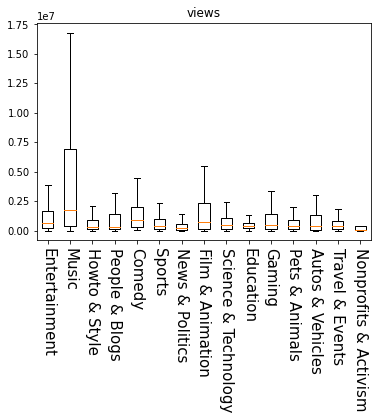

likes: f_score = 63.4383395367562 p_value = 1.3417823975562106e-171


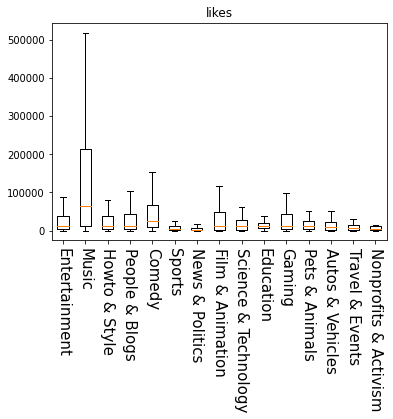

dislikes: f_score = 5.6727080936775875 p_value = 4.131639242032016e-11


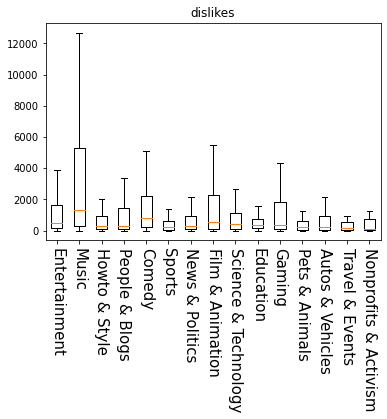

comment_count: f_score = 14.40104240851909 p_value = 7.094228782184063e-35


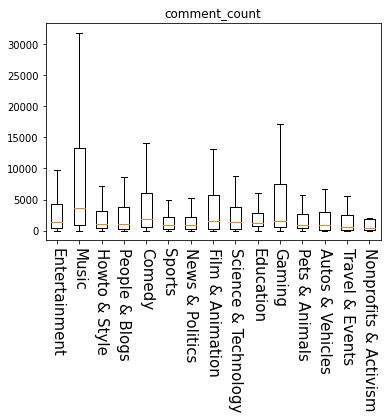

description_len: f_score = 35.28077776411028 p_value = 1.1965109301151156e-93


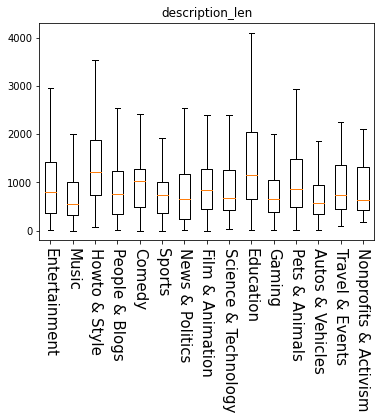

title_len: f_score = 69.97833842678143 p_value = 2.508022805516716e-189


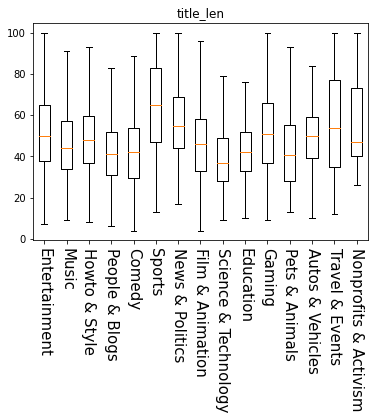

channel_title_len: f_score = 54.26644533116559 p_value = 1.7106414156763909e-146


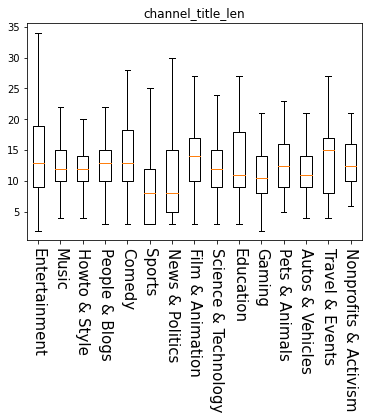

publish_time_day_of_week: f_score = 4.4781752308734175 p_value = 4.232630869892645e-08


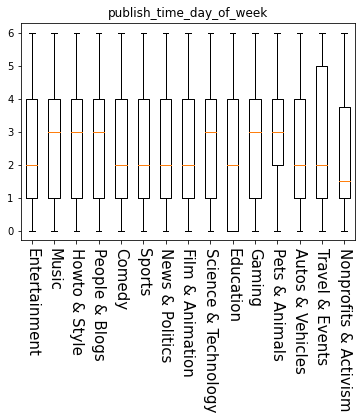

publish_time_hour_of_day: f_score = 19.390014949374397 p_value = 6.799815815987679e-49


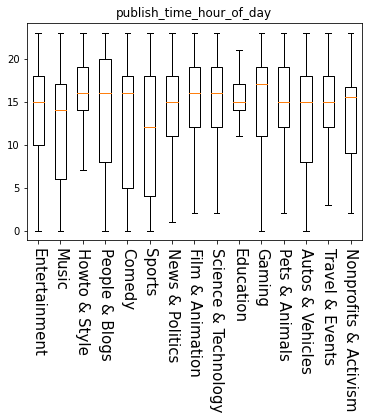

0.46918479532312785


,attr,f score,p value,leq alpha
0,views,42.528430,5.725639e-114,True
1,likes,63.438340,1.341782e-171,True
2,dislikes,5.672708,4.131639e-11,True
3,comment_count,14.401042,7.094229e-35,True
4,description_len,35.280778,1.196511e-93,True
5,title_len,69.978338,2.508023e-189,True
6,channel_title_len,54.266445,1.710641e-146,True
7,publish_time_day_of_week,4.478175,4.232631e-08,True
8,publish_time_hour_of_day,19.390015,6.799816e-49,True


In [43]:
# stats.chi2.pdf()
print(categories)
categories_data = []
N = 0
a = len(categories)
for category_id in categories:
    c_data = videos[videos["new_category_id"] == category_id]
    N += len(c_data)
    categories_data.append(c_data)
print(len(categories_data))

dfn = a - 1
dfd = N - a


def anova(data: List[pd.DataFrame], attr: str):
    data_set = list(map(lambda x: x[attr].dropna(), data))
    f_score, p_value = stats.f_oneway(
        *data_set
    )
    print(f"{attr}: f_score = {f_score} p_value = {p_value}")
    plt.title(attr)
    plt.boxplot(data_set, showfliers=False)
    labels = [categories_dict[i] for i in categories]
    plt.xticks(np.arange(1, len(labels) + 1), labels, rotation=270, fontsize=15)
    plt.show()
    return f_score, p_value


f_scores = pd.DataFrame()
alpha = 0.05
for i in numeric_attrs:
    f, p = anova(categories_data, i)
    f_scores = f_scores.append(pd.DataFrame(
        data={"attr": [i], "f score": [f], "p value": [p], "leq alpha": [p <= alpha]}
    ), ignore_index=True)
print(stats.f.ppf(0.05, dfn, dfd))
f_scores

Poszczególne kategorie mają różne średnie wartości na wszystkich atrybutach ( $$ \alpha = 0.05 $$ )

## Ocena atrybutów tekstowych

Po podaniu tekstów procesowi tokenizacji zostały wygenerowane dla nich cechy
numeryczne, które wyrażają liczbę występujących częstych tokenów przez liczbę wszyskich
często występujących tokenów dla każdej kategorii na każdym atrybucie.

In [44]:
tokenized_attrs = ["channel_titles", "descriptions", "ocr_text", "titles", "domains"]
frequent_attrs = list(filter(lambda x: x.startswith("freq_"), videos.columns.tolist()))
print(frequent_attrs)

## Przygotowanie danych o kategoriach

['freq_channel_titles_Entertainment', 'freq_channel_titles_Music', 'freq_channel_titles_People & Blogs', 'freq_channel_titles_Howto & Style', 'freq_channel_titles_News & Politics', 'freq_channel_titles_Comedy', 'freq_channel_titles_Sports', 'freq_channel_titles_Travel & Events', 'freq_channel_titles_Gaming', 'freq_channel_titles_Education', 'freq_channel_titles_Pets & Animals', 'freq_channel_titles_Science & Technology', 'freq_channel_titles_Film & Animation', 'freq_channel_titles_Autos & Vehicles', 'freq_channel_titles_Nonprofits & Activism', 'freq_channel_titles_Shows', 'freq_descriptions_Entertainment', 'freq_descriptions_Music', 'freq_descriptions_People & Blogs', 'freq_descriptions_Howto & Style', 'freq_descriptions_News & Politics', 'freq_descriptions_Comedy', 'freq_descriptions_Sports', 'freq_descriptions_Travel & Events', 'freq_descriptions_Gaming', 'freq_descriptions_Education', 'freq_descriptions_Pets & Animals', 'freq_descriptions_Science & Technology', 'freq_descriptions_Fi

In [45]:
# categories_ids = pd.unique(videos["category_id"])
#
# categories_dict = get_categories_dict()
# categories = [categories_dict[x] for x in categories_ids if not np.isnan(x)]
# videos["category_name"] = videos["category_id"].apply(lambda x: np.nan if np.isnan(x) else categories_dict[x])
# print(categories_ids)
# print(categories)

## Tytuł kanału

freq_channel_titles_Entertainment: f_score = 128.3763372574517 p_value = 0.0


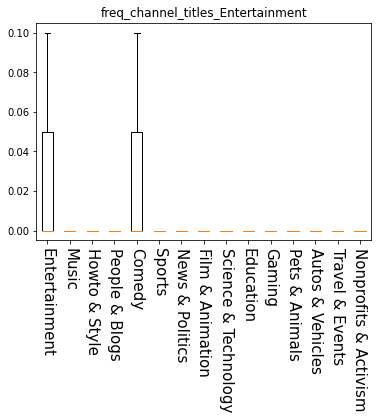

freq_channel_titles_Music: f_score = 43.991996381100904 p_value = 4.781822715237908e-118


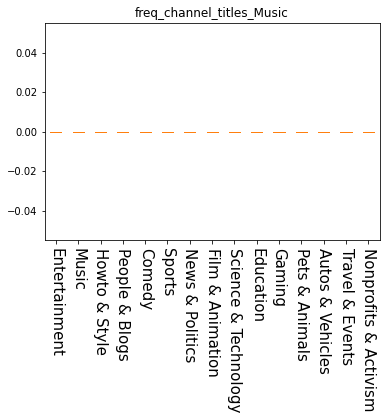

freq_channel_titles_Howto & Style: f_score = 178.93155452155148 p_value = 0.0


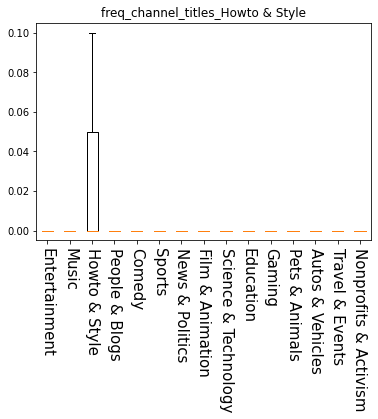

freq_channel_titles_People & Blogs: f_score = 81.52616256666929 p_value = 2.8401957014345547e-220


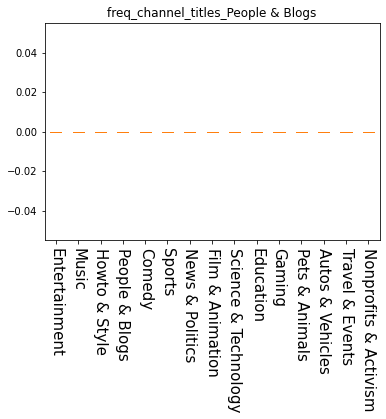

freq_channel_titles_Comedy: f_score = 194.32239420924927 p_value = 0.0


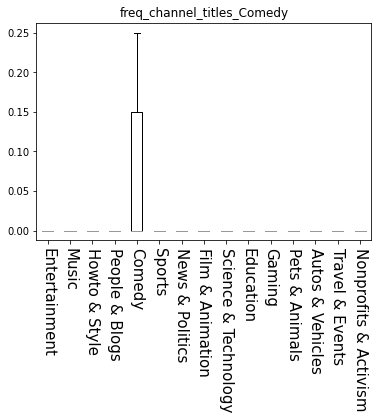

freq_channel_titles_Sports: f_score = 611.7435906662716 p_value = 0.0


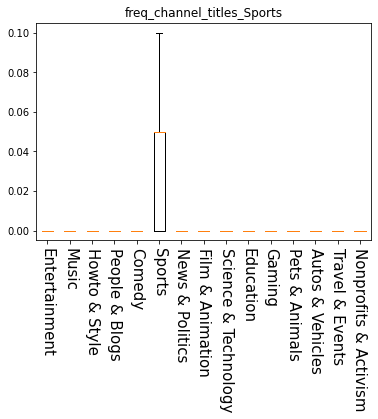

freq_channel_titles_News & Politics: f_score = 647.0465005999087 p_value = 0.0


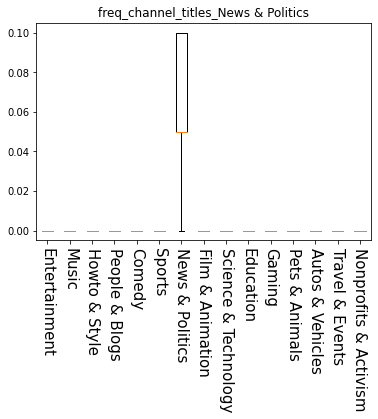

freq_channel_titles_Film & Animation: f_score = 357.7477768567478 p_value = 0.0


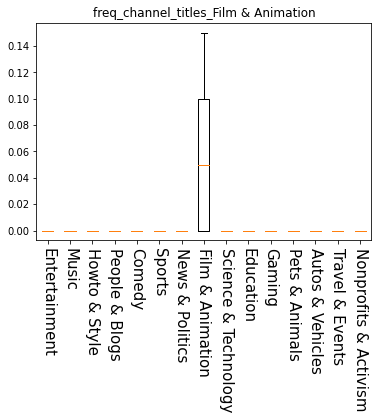

freq_channel_titles_Science & Technology: f_score = 232.19194696032395 p_value = 0.0


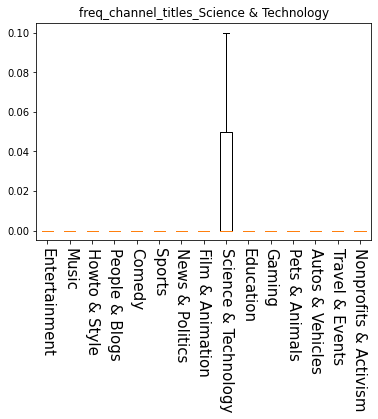

freq_channel_titles_Education: f_score = 378.7437055170192 p_value = 0.0


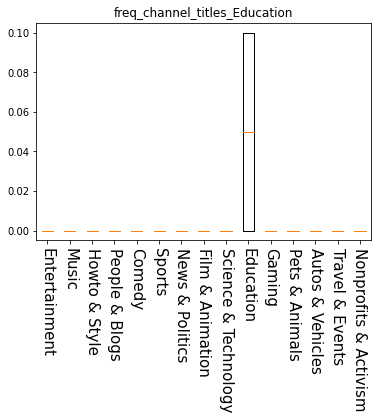

freq_channel_titles_Gaming: f_score = 100.73375648142394 p_value = 9.799721609541256e-271


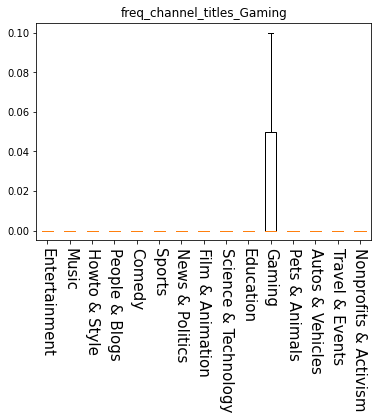

freq_channel_titles_Pets & Animals: f_score = 149.58011810990652 p_value = 0.0


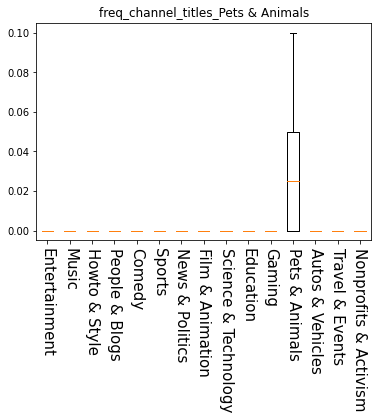

freq_channel_titles_Autos & Vehicles: f_score = 55.748398110627086 p_value = 1.4382875709574937e-150


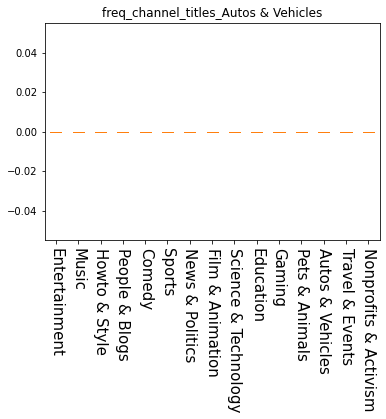

freq_channel_titles_Travel & Events: f_score = 202.134462019231 p_value = 0.0


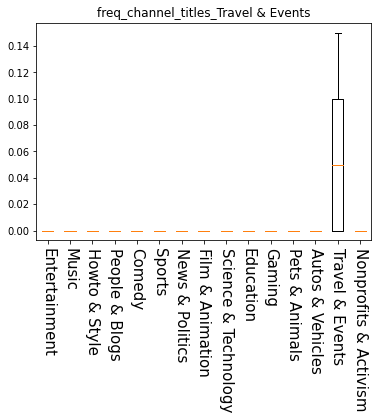

freq_channel_titles_Nonprofits & Activism: f_score = 30.06113656977793 p_value = 5.274798880238771e-79


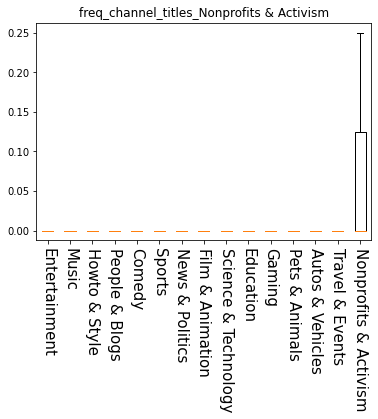

In [46]:
attr = "channel_titles"
for cat in categories:
    attr_name = f"freq_{attr}_{categories_dict[cat]}"
    anova(categories_data, attr_name)

## Tytuł filmu

freq_titles_Entertainment: f_score = 89.12749829303566 p_value = 2.151918059892368e-240


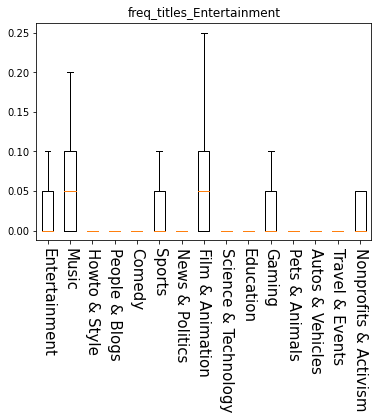

freq_titles_Music: f_score = 269.7225411852963 p_value = 0.0


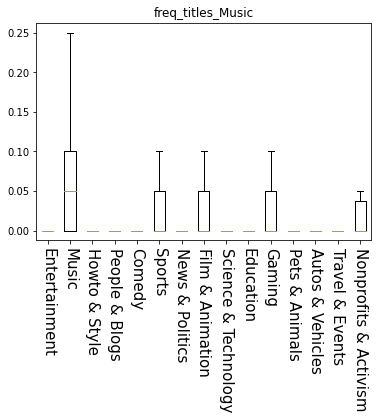

freq_titles_Howto & Style: f_score = 80.98497252268234 p_value = 7.823719290138975e-219


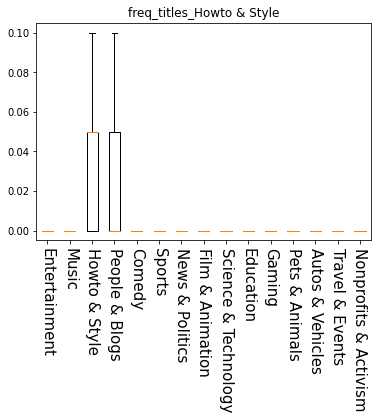

freq_titles_People & Blogs: f_score = 50.978357876168815 p_value = 1.9984719242389067e-137


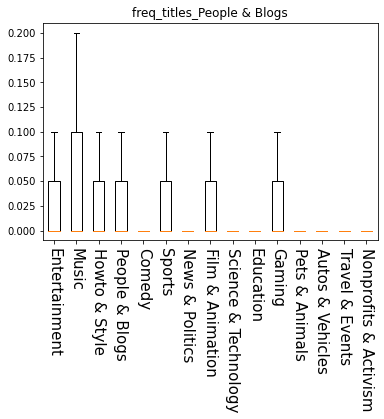

freq_titles_Comedy: f_score = 74.18942133909277 p_value = 1.1519263370501751e-200


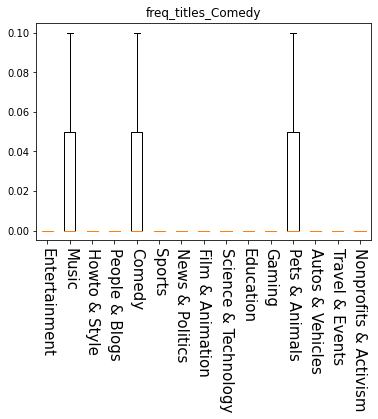

freq_titles_Sports: f_score = 237.2557205636025 p_value = 0.0


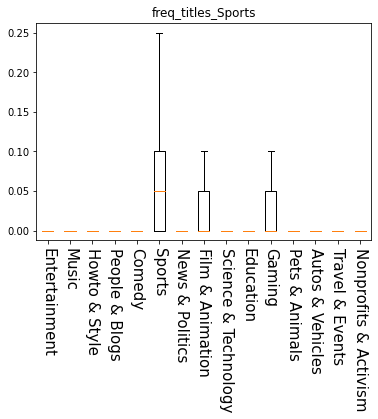

freq_titles_News & Politics: f_score = 65.72953978383279 p_value = 7.94758309868732e-178


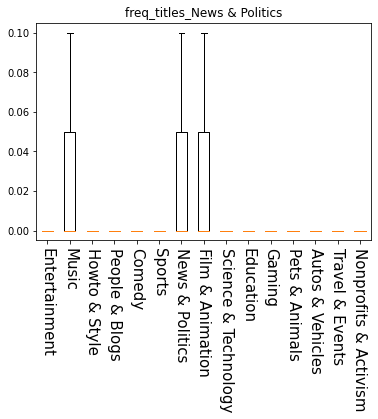

freq_titles_Film & Animation: f_score = 157.26975103619966 p_value = 0.0


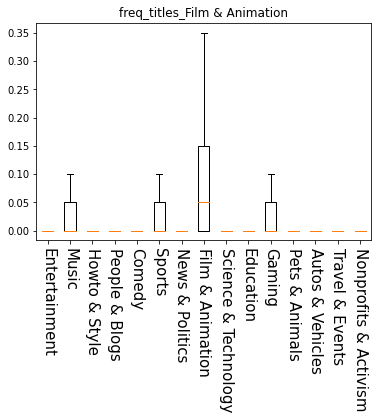

freq_titles_Science & Technology: f_score = 42.82815767393468 p_value = 8.358528966679684e-115


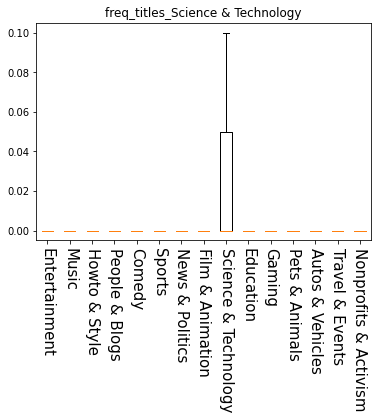

freq_titles_Education: f_score = 16.4668552996255 p_value = 1.1483136740284026e-40


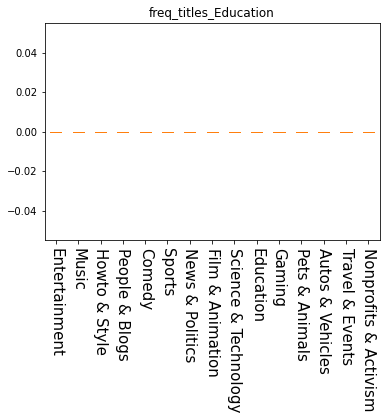

freq_titles_Gaming: f_score = 74.64012279428046 p_value = 7.104919444044095e-202


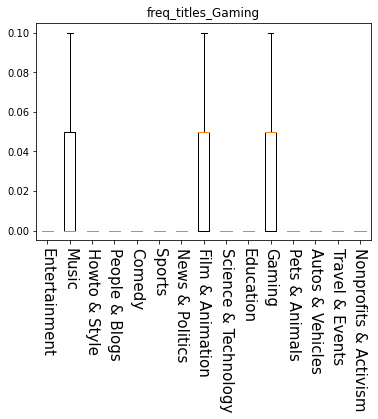

freq_titles_Pets & Animals: f_score = 118.96842731132638 p_value = 1.711541e-317


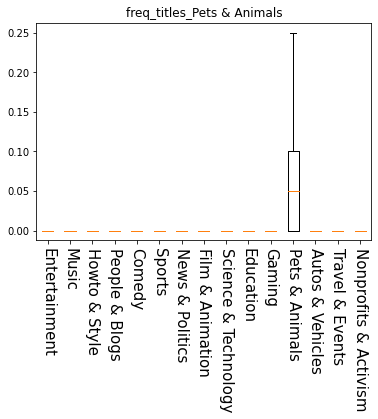

freq_titles_Autos & Vehicles: f_score = 37.3866972346459 p_value = 1.3565073974185667e-99


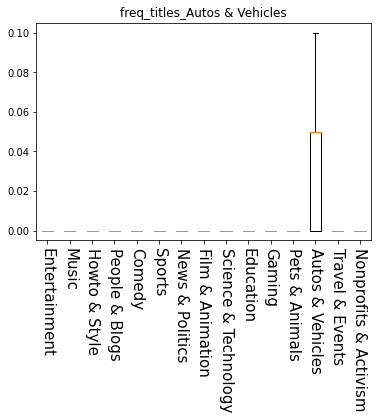

freq_titles_Travel & Events: f_score = 102.03930794604874 p_value = 4.0427664465523123e-274


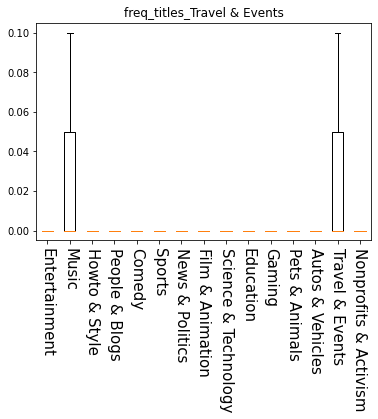

freq_titles_Nonprofits & Activism: f_score = 52.56977059832934 p_value = 8.085797517339099e-142


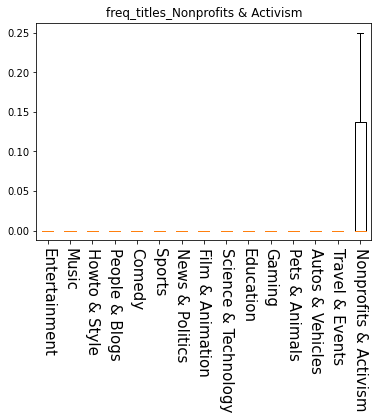

In [47]:
attr = "titles"
for cat in categories:
    attr_name = f"freq_{attr}_{categories_dict[cat]}"
    anova(categories_data, attr_name)


## Opisy filmów

freq_descriptions_Entertainment: f_score = 44.29556836218799 p_value = 6.830764018368688e-119


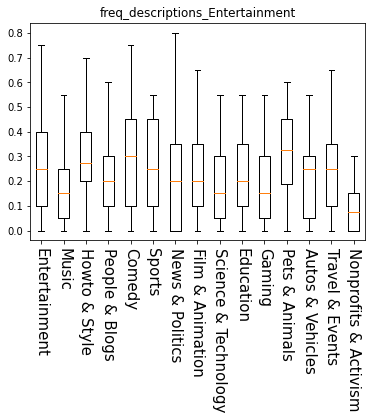

freq_descriptions_Music: f_score = 40.727335306235915 p_value = 6.094559757786883e-109


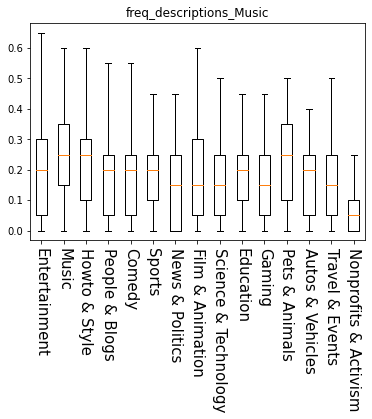

freq_descriptions_Howto & Style: f_score = 68.93129441907558 p_value = 1.6897145383121154e-186


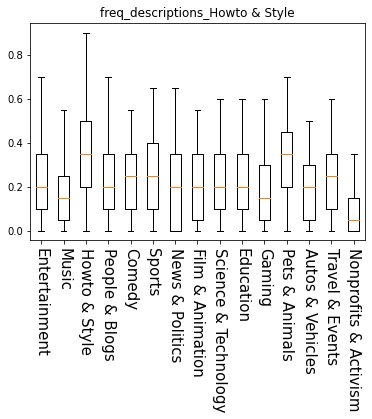

freq_descriptions_People & Blogs: f_score = 39.56658360108933 p_value = 1.0703152792388097e-105


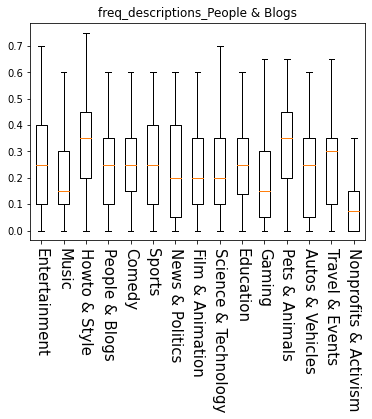

freq_descriptions_Comedy: f_score = 60.35614282884497 p_value = 3.412096513199143e-163


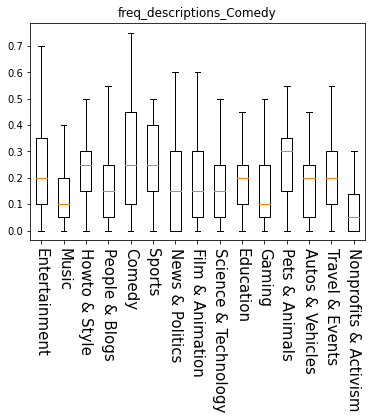

freq_descriptions_Sports: f_score = 85.78979659837641 p_value = 1.3908168043054386e-231


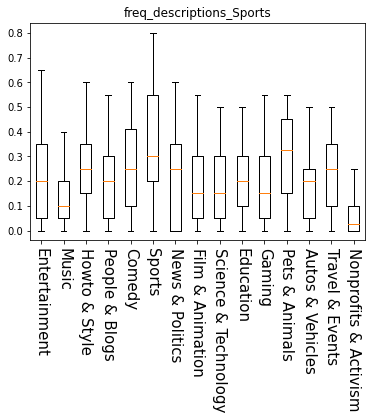

freq_descriptions_News & Politics: f_score = 48.212358089186665 p_value = 9.018220113011574e-130


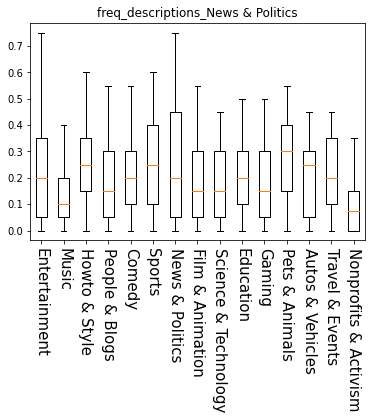

freq_descriptions_Film & Animation: f_score = 38.36161107501394 p_value = 2.5205195519433754e-102


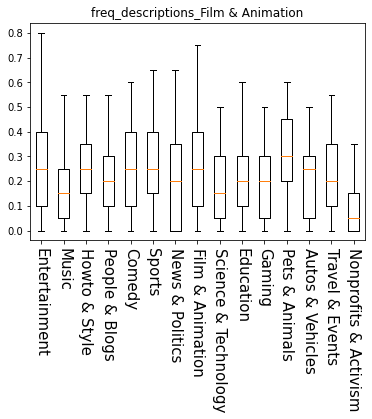

freq_descriptions_Science & Technology: f_score = 58.18238966608195 p_value = 3.020885184444937e-157


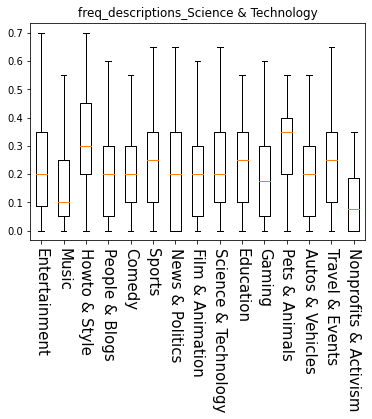

freq_descriptions_Education: f_score = 88.08498525846132 p_value = 1.204012885525447e-237


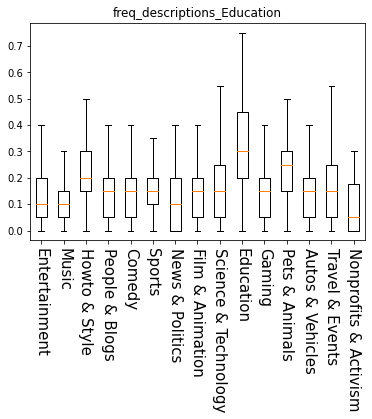

freq_descriptions_Gaming: f_score = 41.93073330520261 p_value = 2.6611767086170513e-112


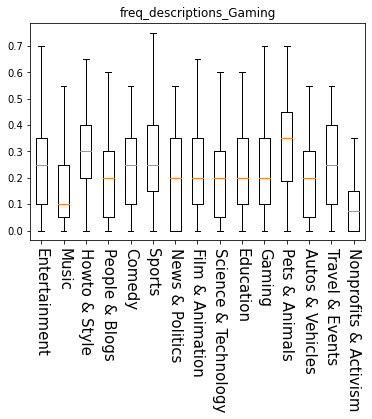

freq_descriptions_Pets & Animals: f_score = 52.3301413912904 p_value = 3.704096998326927e-141


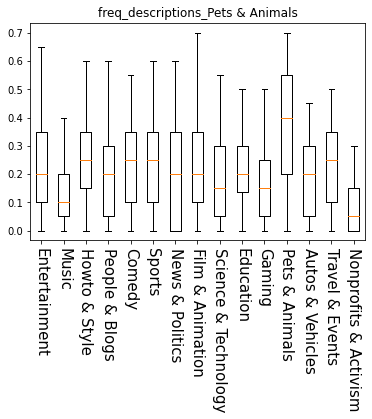

freq_descriptions_Autos & Vehicles: f_score = 40.99664841915947 p_value = 1.0781397272572507e-109


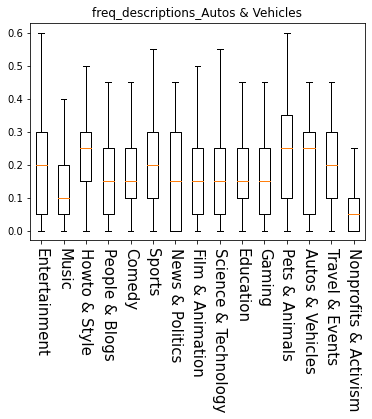

freq_descriptions_Travel & Events: f_score = 63.610515900799804 p_value = 4.5613286940401066e-172


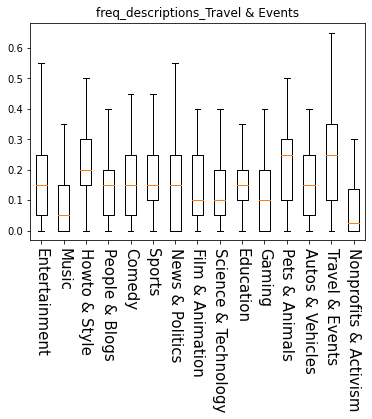

freq_descriptions_Nonprofits & Activism: f_score = 38.97655218105686 p_value = 4.788187054499445e-104


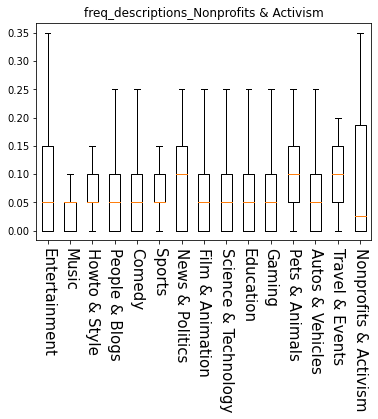

In [48]:
attr = "descriptions"
for cat in categories:
    attr_name = f"freq_{attr}_{categories_dict[cat]}"
    anova(categories_data, attr_name)

## OCR

freq_ocr_text_Entertainment: f_score = 8.17018552583446 p_value = 1.0606570564659437e-17


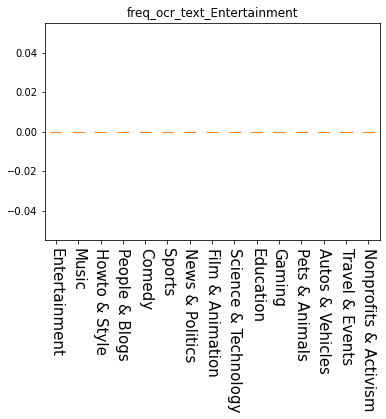

freq_ocr_text_Music: f_score = 11.905878265561801 p_value = 6.303407643040712e-28


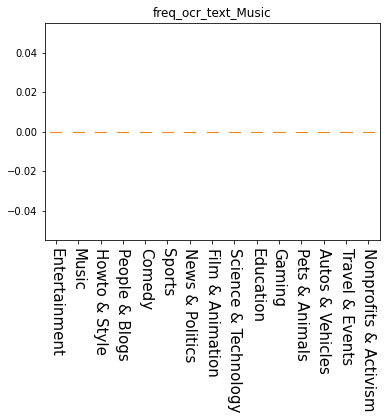

freq_ocr_text_Howto & Style: f_score = 5.30750868378731 p_value = 3.546222662522527e-10


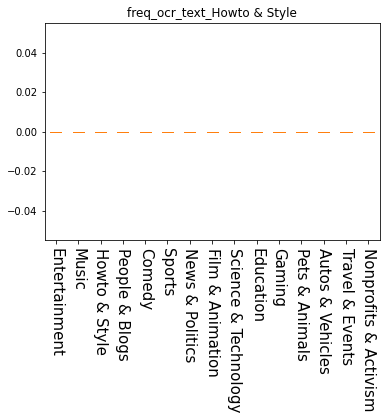

freq_ocr_text_People & Blogs: f_score = 2.4971897721484146 p_value = 0.0015133178171791827


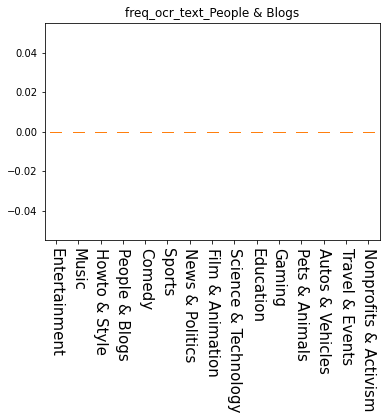

freq_ocr_text_Comedy: f_score = 6.348535305593259 p_value = 7.311927546681983e-13


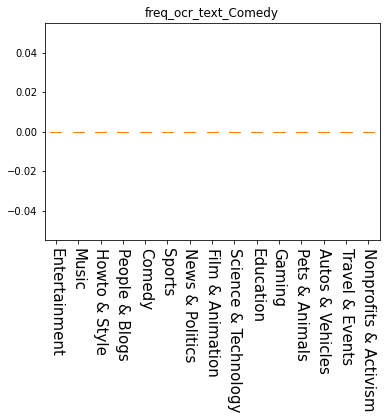

freq_ocr_text_Sports: f_score = 5.211130895456921 p_value = 6.228691895281753e-10


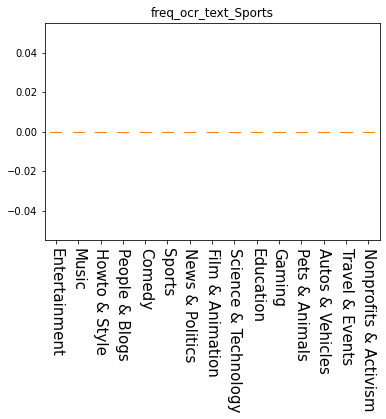

freq_ocr_text_News & Politics: f_score = 3.1258936793358467 p_value = 6.657495582261519e-05


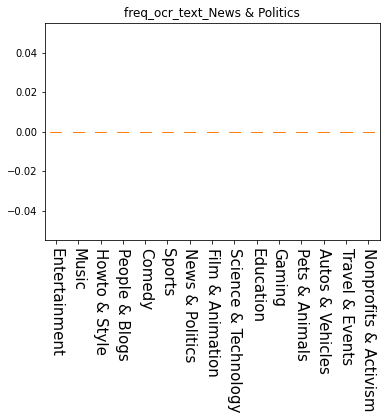

freq_ocr_text_Film & Animation: f_score = 11.775187885284867 p_value = 1.4508055410989005e-27


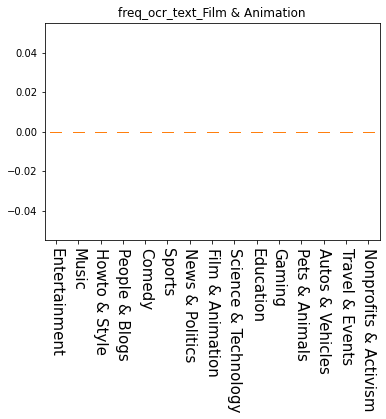

freq_ocr_text_Science & Technology: f_score = 2.554164545255585 p_value = 0.001153075178336802


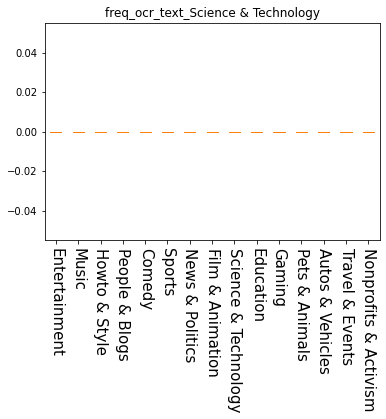

freq_ocr_text_Education: f_score = 9.930662899062872 p_value = 1.7493747702932134e-22


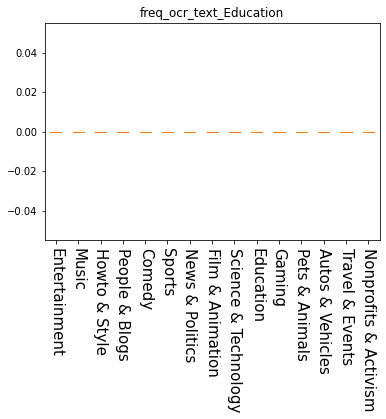

freq_ocr_text_Gaming: f_score = 13.794739043899911 p_value = 3.5066224727678416e-33


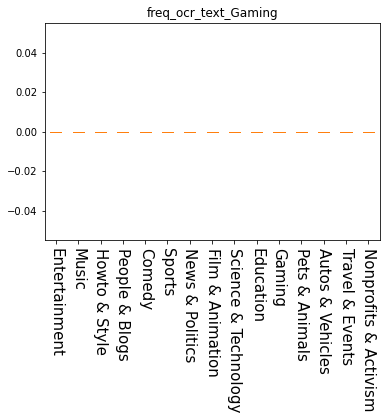

freq_ocr_text_Pets & Animals: f_score = 2.6867212537852874 p_value = 0.0006067713271020948


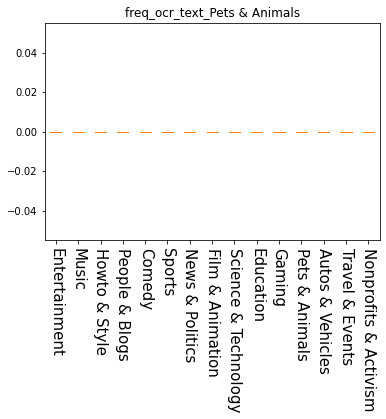

freq_ocr_text_Autos & Vehicles: f_score = 17.398642570937927 p_value = 2.7588067067829346e-43


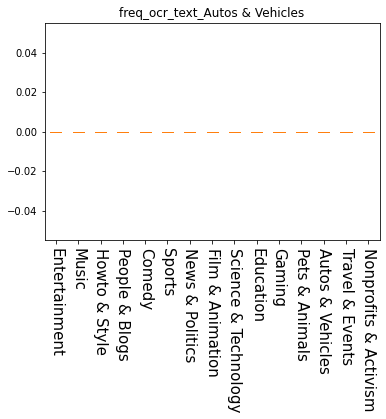

freq_ocr_text_Travel & Events: f_score = 2.090313152748687 p_value = 0.009709724817793426


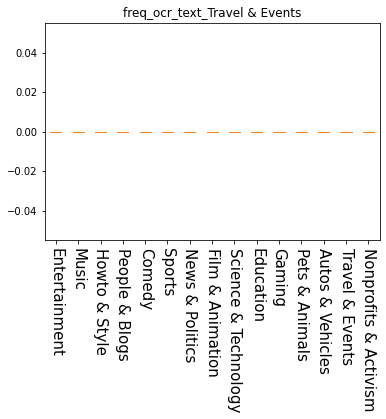

freq_ocr_text_Nonprofits & Activism: f_score = 36.7172472683994 p_value = 1.0211001540105284e-97


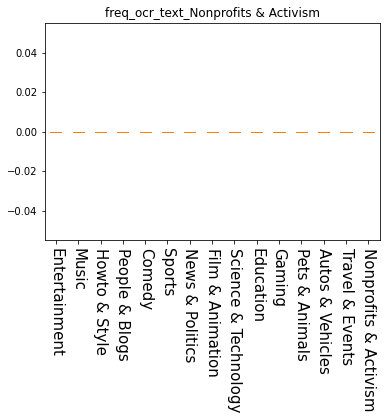

In [49]:
attr = "ocr_text"
for cat in categories:
    attr_name = f"freq_{attr}_{categories_dict[cat]}"
    anova(categories_data, attr_name)


## Domeny

freq_domains_Entertainment: f_score = 32.43055747908081 p_value = 1.1231458696558897e-85


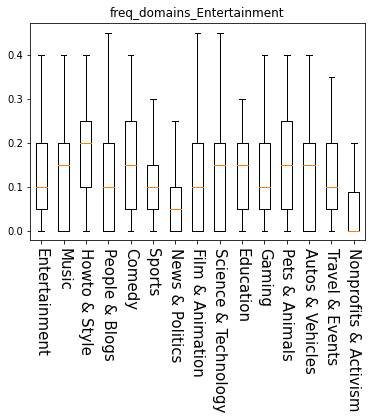

freq_domains_Music: f_score = 38.99692613308686 p_value = 4.1991176682660725e-104


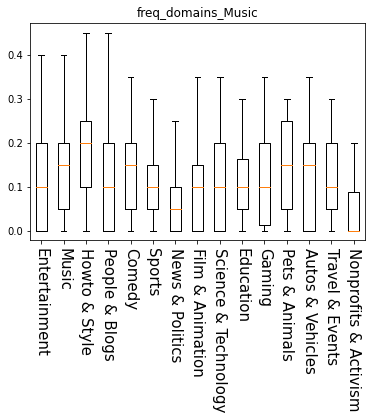

freq_domains_Howto & Style: f_score = 40.27477555032688 p_value = 1.1207713240568483e-107


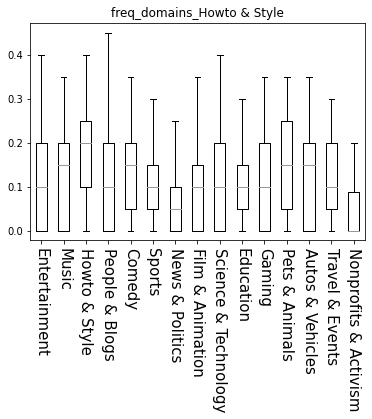

freq_domains_People & Blogs: f_score = 34.98340865110975 p_value = 7.490211867748166e-93


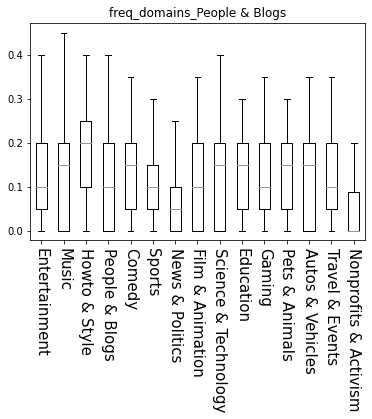

freq_domains_Comedy: f_score = 43.942179767304786 p_value = 6.581204746886253e-118


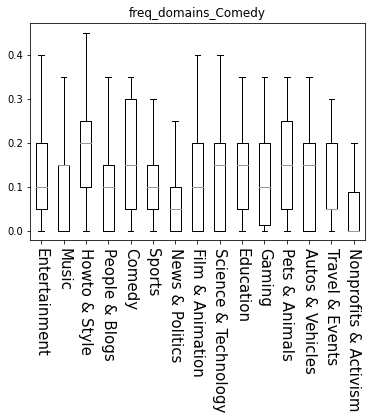

freq_domains_Sports: f_score = 37.519157038161296 p_value = 5.770774264191426e-100


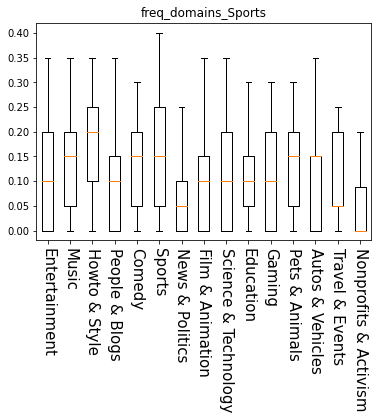

freq_domains_News & Politics: f_score = 20.534045310644945 p_value = 4.038473019288869e-52


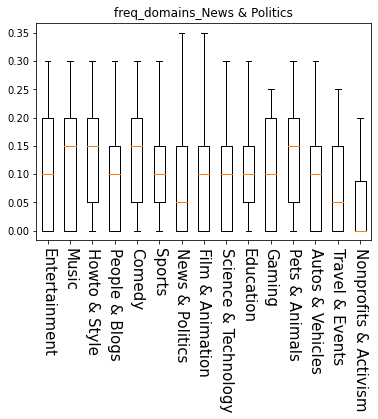

freq_domains_Film & Animation: f_score = 27.96171970856616 p_value = 4.37735133579935e-73


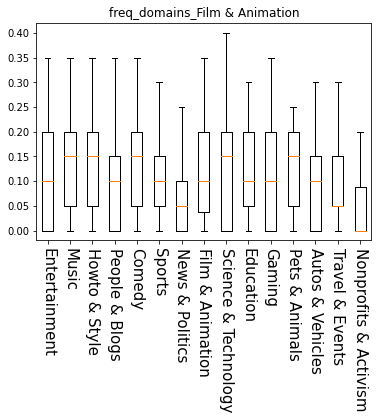

freq_domains_Science & Technology: f_score = 33.469960915451 p_value = 1.3398630484398827e-88


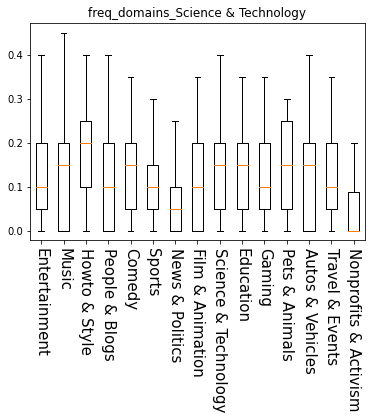

freq_domains_Education: f_score = 39.50441195465642 p_value = 1.5973432972723379e-105


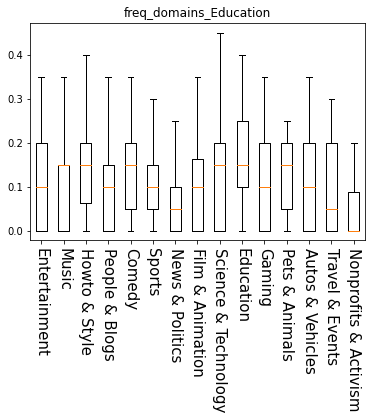

freq_domains_Gaming: f_score = 32.496824619771864 p_value = 7.311249586949364e-86


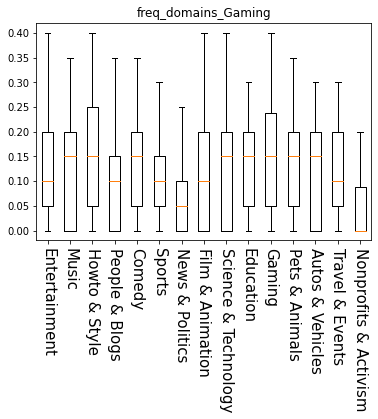

freq_domains_Pets & Animals: f_score = 30.780304833045268 p_value = 4.967529214222798e-81


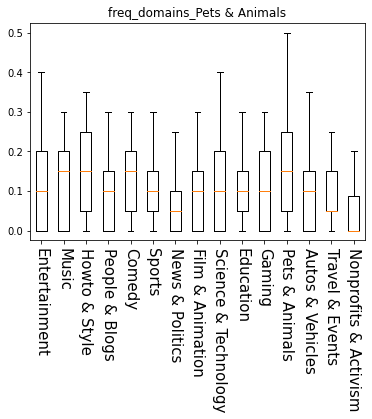

freq_domains_Autos & Vehicles: f_score = 33.21068591344835 p_value = 7.179237249969661e-88


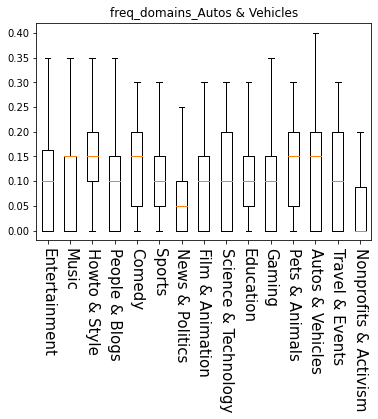

freq_domains_Travel & Events: f_score = 28.901743801954616 p_value = 9.776679218919952e-76


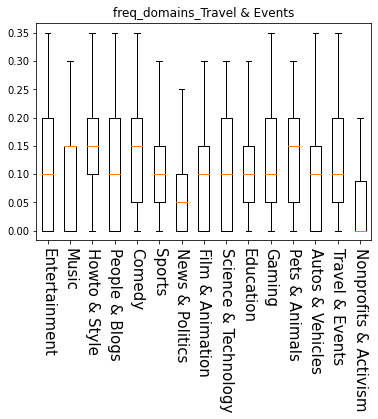

freq_domains_Nonprofits & Activism: f_score = 51.802780534825544 p_value = 1.0566463898003763e-139


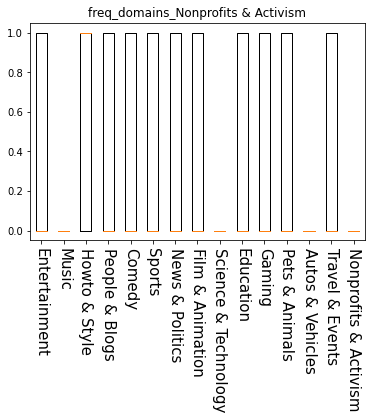

In [50]:
attr = "domains"
for cat in categories:
    attr_name = f"freq_{attr}_{categories_dict[cat]}"
    anova(categories_data, attr_name)

## TAGI

freq_tags_Entertainment: f_score = 117.27326770221421 p_value = 3.41882260984e-313


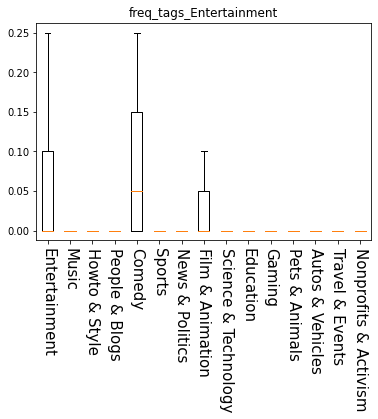

freq_tags_Music: f_score = 176.47720853900836 p_value = 0.0


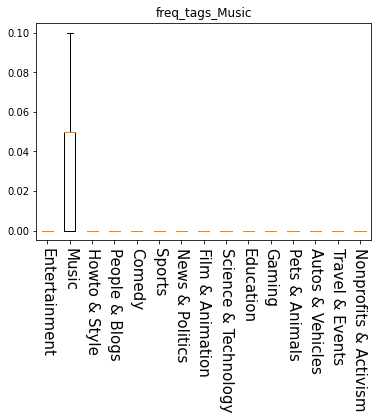

freq_tags_Howto & Style: f_score = 182.504537354182 p_value = 0.0


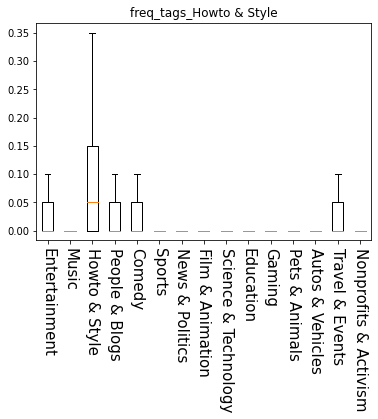

freq_tags_People & Blogs: f_score = 89.39743311094924 p_value = 4.187447779521239e-241


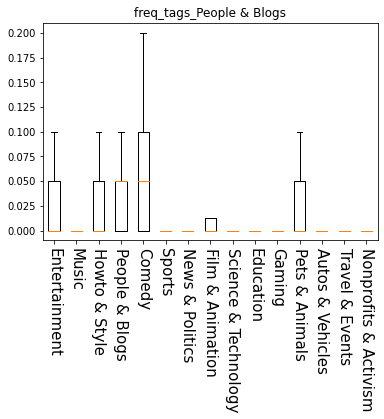

freq_tags_Comedy: f_score = 158.1549798060956 p_value = 0.0


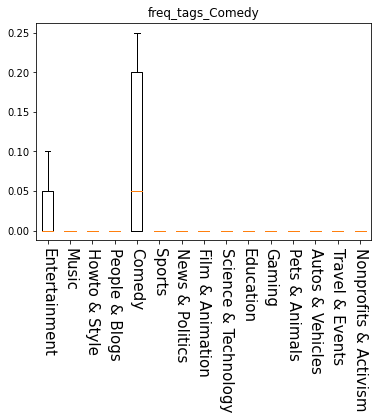

freq_tags_Sports: f_score = 408.2445674034691 p_value = 0.0


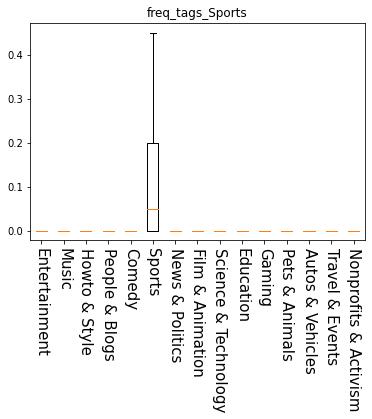

freq_tags_News & Politics: f_score = 164.6318538743838 p_value = 0.0


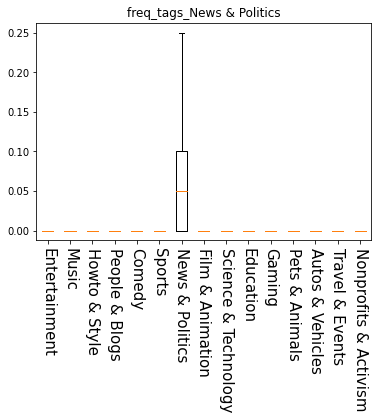

freq_tags_Film & Animation: f_score = 140.2044720872944 p_value = 0.0


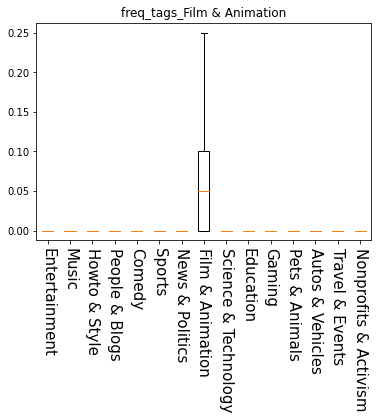

freq_tags_Science & Technology: f_score = 96.47928385267436 p_value = 1.1493302687718023e-259


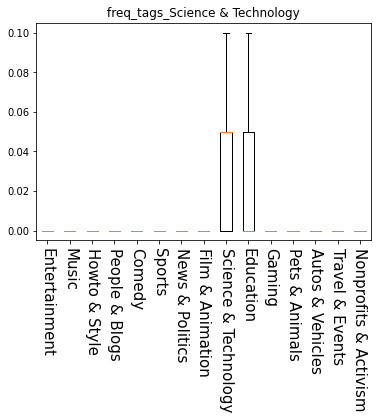

freq_tags_Education: f_score = 365.1190374108181 p_value = 0.0


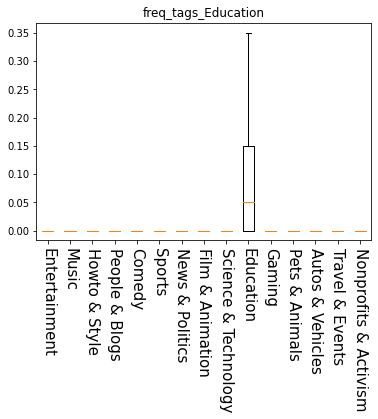

freq_tags_Gaming: f_score = 75.01649141003273 p_value = 6.946518436380218e-203


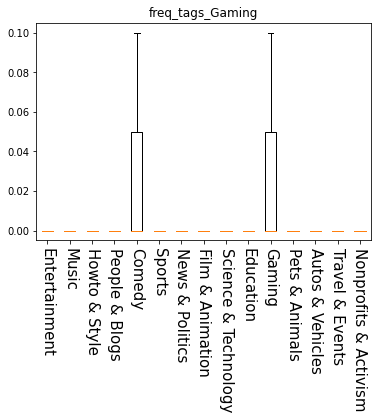

freq_tags_Pets & Animals: f_score = 275.85940879909936 p_value = 0.0


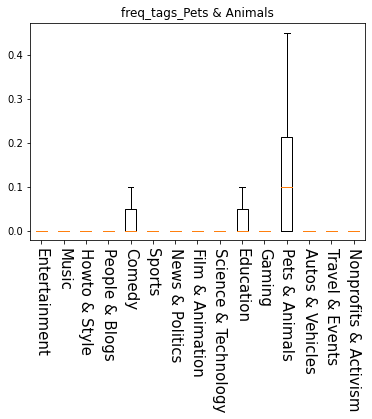

freq_tags_Autos & Vehicles: f_score = 32.92548906712965 p_value = 4.551370733444842e-87


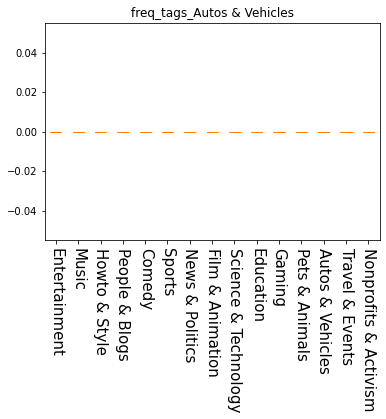

freq_tags_Travel & Events: f_score = 94.06183105503747 p_value = 2.3846230055869408e-253


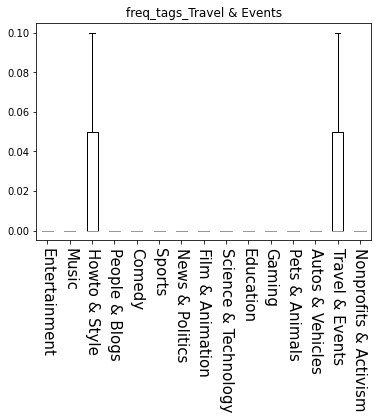

freq_tags_Nonprofits & Activism: f_score = 64.8567237776013 p_value = 1.863959794993084e-175


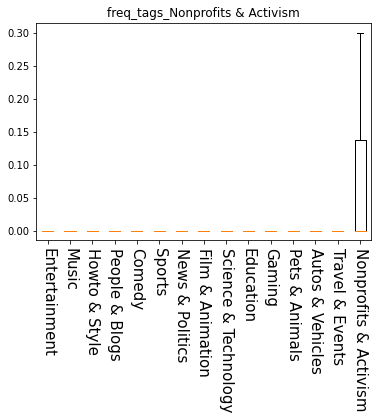

In [51]:
attr = "tags"
for cat in categories:
    attr_name = f"freq_{attr}_{categories_dict[cat]}"
    anova(categories_data, attr_name)


## Emocje TODO

In [52]:
videos["tokenized_emotion"] = videos["emotions"].apply(lambda x: [eval(x)[-1]] if eval(x) else np.nan)
# plot_categories_bars(categories, "emotion", create_tokens_dict=False)


NameError: name 'plot_categories_bars' is not defined

Zapisanie ostatecznego zbioru danych.

In [ ]:
# TODO